In [1]:
library(dplyr)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



In [2]:
library(ggplot2)

Warning message:
"package 'ggplot2' was built under R version 3.5.2"

In [3]:
library(scales)

In [4]:
library(caTools)

Warning message:
"package 'caTools' was built under R version 3.5.2"

In [5]:
library(rpart)

Warning message:
"package 'rpart' was built under R version 3.5.2"

In [7]:
library(rpart.plot)

In [8]:
#read data train and test
titanic_train = read.csv('train.csv')
titanic_test = read.csv('test.csv')

In [9]:
#bind data together
titanic <- bind_rows(titanic_train, titanic_test)

Warning message in bind_rows_(x, .id):
"Unequal factor levels: coercing to character"Warning message in bind_rows_(x, .id):
"binding character and factor vector, coercing into character vector"Warning message in bind_rows_(x, .id):
"binding character and factor vector, coercing into character vector"Warning message in bind_rows_(x, .id):
"Unequal factor levels: coercing to character"Warning message in bind_rows_(x, .id):
"binding character and factor vector, coercing into character vector"Warning message in bind_rows_(x, .id):
"binding character and factor vector, coercing into character vector"Warning message in bind_rows_(x, .id):
"Unequal factor levels: coercing to character"Warning message in bind_rows_(x, .id):
"binding character and factor vector, coercing into character vector"Warning message in bind_rows_(x, .id):
"binding character and factor vector, coercing into character vector"Warning message in bind_rows_(x, .id):
"Unequal factor levels: coercing to character"Warning mess

In [10]:
str(titanic)

'data.frame':	1309 obs. of  12 variables:
 $ PassengerId: int  1 2 3 4 5 6 7 8 9 10 ...
 $ Survived   : int  0 1 1 1 0 0 0 0 1 1 ...
 $ Pclass     : int  3 1 3 1 3 3 1 3 3 2 ...
 $ Name       : chr  "Braund, Mr. Owen Harris" "Cumings, Mrs. John Bradley (Florence Briggs Thayer)" "Heikkinen, Miss. Laina" "Futrelle, Mrs. Jacques Heath (Lily May Peel)" ...
 $ Sex        : Factor w/ 2 levels "female","male": 2 1 1 1 2 2 2 2 1 1 ...
 $ Age        : num  22 38 26 35 35 NA 54 2 27 14 ...
 $ SibSp      : int  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch      : int  0 0 0 0 0 0 0 1 2 0 ...
 $ Ticket     : chr  "A/5 21171" "PC 17599" "STON/O2. 3101282" "113803" ...
 $ Fare       : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Cabin      : chr  "" "C85" "" "C123" ...
 $ Embarked   : chr  "S" "C" "S" "S" ...


In [11]:
#how many missing values in dataset

colSums(is.na(titanic)|titanic=='')

PassengerId    Survived      Pclass        Name         Sex         Age 
          0         418           0           0           0         263 
      SibSp       Parch      Ticket        Fare       Cabin    Embarked 
          0           0           0           1        1014           2

In [12]:
#fare has onlyone missing value handling that first using median concept
titanic$Fare[is.na(titanic$Fare)==TRUE] = median(filter(titanic, Pclass==3 & Embarked=="S")$Fare, na.rm=TRUE)

Warning message:
"package 'bindrcpp' was built under R version 3.5.2"

In [13]:
colSums(is.na(titanic)|titanic=='')

PassengerId    Survived      Pclass        Name         Sex         Age 
          0         418           0           0           0         263 
      SibSp       Parch      Ticket        Fare       Cabin    Embarked 
          0           0           0           0        1014           2

In [14]:
#using Pclass imputing value of age as it is one of the most import factor
impute.age <- function(age,class){
  vector <- age
  for (i in 1:length(age)){
    if (is.na(age[i])){
      if (class[i] == 1){
        vector[i] <- round(mean(filter(titanic,Pclass==1)$Age, na.rm=TRUE),0)
      }else if (class[i] == 2){
        vector[i] <- round(mean(filter(titanic,Pclass==2)$Age, na.rm=TRUE),0)
      }else{
        vector[i] <- round(mean(filter(titanic,Pclass==3)$Age, na.rm=TRUE),0)
      }
    }else{
      vector[i]<-age[i]
    }
  }
  return(vector)
}
imputed.age <- impute.age(titanic$Age,titanic$Pclass)
titanic$Age <- imputed.age

In [15]:
#age attribute handled
colSums(is.na(titanic)|titanic=='')

PassengerId    Survived      Pclass        Name         Sex         Age 
          0         418           0           0           0           0 
      SibSp       Parch      Ticket        Fare       Cabin    Embarked 
          0           0           0           0        1014           2

In [16]:
#now we will see attribute name for some understanding
head(titanic$Name)
titanic$Title <- gsub("^.*, (.*?)\\..*$", "\\1", titanic$Name)

[1] "Braund, Mr. Owen Harris"                            
[2] "Cumings, Mrs. John Bradley (Florence Briggs Thayer)"
[3] "Heikkinen, Miss. Laina"                             
[4] "Futrelle, Mrs. Jacques Heath (Lily May Peel)"       
[5] "Allen, Mr. William Henry"                           
[6] "Moran, Mr. James"

In [17]:
# frequency of each title by sex
table(titanic$Sex, titanic$Title)

        
         Capt Col Don Dona  Dr Jonkheer Lady Major Master Miss Mlle Mme  Mr Mrs
  female    0   0   0    1   1        0    1     0      0  260    2   1   0 197
  male      1   4   1    0   7        1    0     2     61    0    0   0 757   0
        
          Ms Rev Sir the Countess
  female   2   0   0            1
  male     0   8   1            0

In [18]:
#correct some name
titanic$Title[titanic$Title == 'Mlle' | titanic$Title == 'Ms'] <- 'Miss' 
titanic$Title[titanic$Title == 'Mme']  <- 'Mrs' 

In [19]:
# create a new category with low frequency of titles
Other <- c('Dona', 'Dr', 'Lady', 'the Countess','Capt', 'Col', 'Don', 'Jonkheer', 'Major', 'Rev', 'Sir')
titanic$Title[titanic$Title %in% Other]  <- 'Other'

In [20]:
# see what happened by above two steps
table(titanic$Sex, titanic$Title)

        
         Master Miss  Mr Mrs Other
  female      0  264   0 198     4
  male       61    0 757   0    25

In [21]:
colSums(is.na(titanic)|titanic=='')

PassengerId    Survived      Pclass        Name         Sex         Age 
          0         418           0           0           0           0 
      SibSp       Parch      Ticket        Fare       Cabin    Embarked 
          0           0           0           0        1014           2 
      Title 
          0

In [22]:
# Embarked has only two missing value
str(titanic$Embarked)

 chr [1:1309] "S" "C" "S" "S" "S" "Q" "S" "S" "S" "C" "S" "S" "S" "S" "S" ...


In [23]:
#we will see that c class has most occurance so replace that two missing values by the S class
length(titanic[titanic$Embarked=='S',c(1)])

[1] 914

In [24]:
titanic$Embarked[titanic$Embarked==""] = "S"

In [25]:
colSums(is.na(titanic)|titanic=='')

PassengerId    Survived      Pclass        Name         Sex         Age 
          0         418           0           0           0           0 
      SibSp       Parch      Ticket        Fare       Cabin    Embarked 
          0           0           0           0        1014           0 
      Title 
          0

In [26]:
#NOW WE HAVE REMOVED ALL MISSING VALUES OF REQUIRED PARAMETER
#NOW WE CREATE NEW ATTRIBUTE FAMILY SIZE
FamilySize <- titanic$SibSp + titanic$Parch + 1

table(FamilySize)

FamilySize
  1   2   3   4   5   6   7   8  11 
790 235 159  43  22  25  16   8  11 

In [27]:
#now convert it into three variables single large small
titanic$FamilySize <- sapply(1:nrow(titanic), function(x) 
  ifelse(FamilySize[x]==1, "Single", 
         ifelse(FamilySize[x]>4, "Large", "Small")))

table(titanic$FamilySize)


 Large Single  Small 
    82    790    437 

In [28]:
str(titanic)

'data.frame':	1309 obs. of  14 variables:
 $ PassengerId: int  1 2 3 4 5 6 7 8 9 10 ...
 $ Survived   : int  0 1 1 1 0 0 0 0 1 1 ...
 $ Pclass     : int  3 1 3 1 3 3 1 3 3 2 ...
 $ Name       : chr  "Braund, Mr. Owen Harris" "Cumings, Mrs. John Bradley (Florence Briggs Thayer)" "Heikkinen, Miss. Laina" "Futrelle, Mrs. Jacques Heath (Lily May Peel)" ...
 $ Sex        : Factor w/ 2 levels "female","male": 2 1 1 1 2 2 2 2 1 1 ...
 $ Age        : num  22 38 26 35 35 25 54 2 27 14 ...
 $ SibSp      : int  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch      : int  0 0 0 0 0 0 0 1 2 0 ...
 $ Ticket     : chr  "A/5 21171" "PC 17599" "STON/O2. 3101282" "113803" ...
 $ Fare       : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Cabin      : chr  "" "C85" "" "C123" ...
 $ Embarked   : chr  "S" "C" "S" "S" ...
 $ Title      : chr  "Mr" "Mrs" "Miss" "Mrs" ...
 $ FamilySize : chr  "Small" "Small" "Single" "Small" ...


In [29]:
#convert categorical attributes to factor
titanic$Survived = factor(titanic$Survived)
titanic$Pclass = factor(titanic$Pclass)
titanic$Sex = factor(titanic$Sex)
titanic$Embarked = factor(titanic$Embarked)
titanic$Title = factor(titanic$Title)
titanic$FamilySize = factor(titanic$FamilySize, levels=c("Single","Small","Large"))

In [30]:
str(titanic)

'data.frame':	1309 obs. of  14 variables:
 $ PassengerId: int  1 2 3 4 5 6 7 8 9 10 ...
 $ Survived   : Factor w/ 2 levels "0","1": 1 2 2 2 1 1 1 1 2 2 ...
 $ Pclass     : Factor w/ 3 levels "1","2","3": 3 1 3 1 3 3 1 3 3 2 ...
 $ Name       : chr  "Braund, Mr. Owen Harris" "Cumings, Mrs. John Bradley (Florence Briggs Thayer)" "Heikkinen, Miss. Laina" "Futrelle, Mrs. Jacques Heath (Lily May Peel)" ...
 $ Sex        : Factor w/ 2 levels "female","male": 2 1 1 1 2 2 2 2 1 1 ...
 $ Age        : num  22 38 26 35 35 25 54 2 27 14 ...
 $ SibSp      : int  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch      : int  0 0 0 0 0 0 0 1 2 0 ...
 $ Ticket     : chr  "A/5 21171" "PC 17599" "STON/O2. 3101282" "113803" ...
 $ Fare       : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Cabin      : chr  "" "C85" "" "C123" ...
 $ Embarked   : Factor w/ 3 levels "C","Q","S": 3 1 3 3 3 2 3 3 3 1 ...
 $ Title      : Factor w/ 5 levels "Master","Miss",..: 3 4 2 4 3 3 3 1 4 4 ...
 $ FamilySize : Factor w/ 3 levels "Single","Small",.

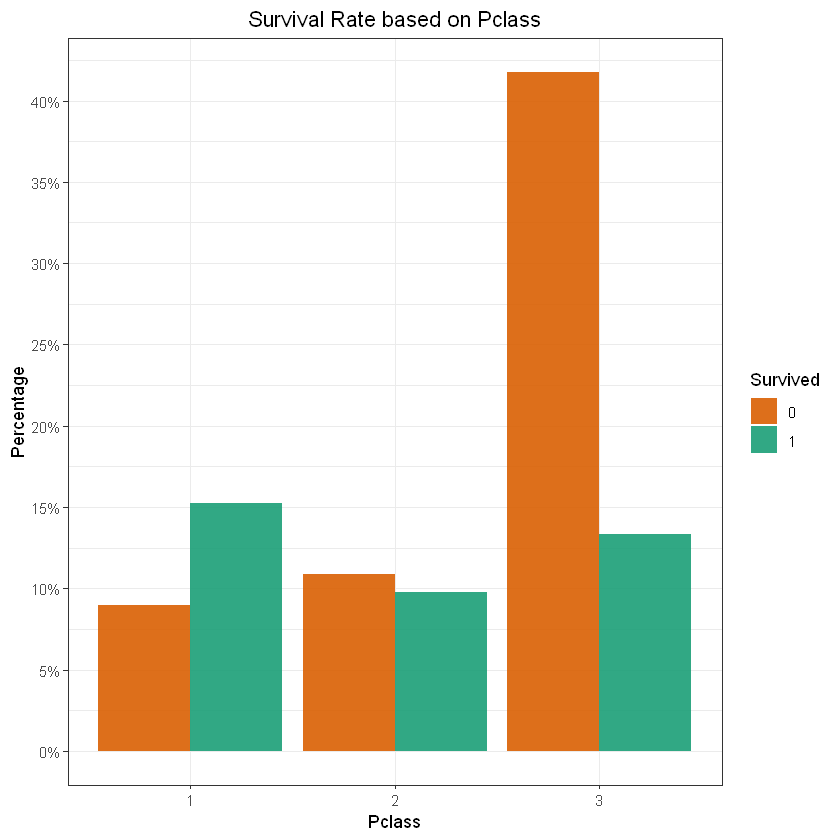

In [31]:
#first inference 
#based on Pclass
ggplot(filter(titanic, is.na(Survived)==FALSE), aes(Pclass, fill=Survived)) + 
  geom_bar(aes(y = (..count..)/sum(..count..)), alpha=0.9, position="dodge") +
  scale_fill_brewer(palette = "Dark2", direction = -1) +
  scale_y_continuous(labels=percent, breaks=seq(0,0.6,0.05)) +
  ylab("Percentage") + 
  ggtitle("Survival Rate based on Pclass") +
  theme_bw() +
  theme(plot.title = element_text(hjust = 0.5))

In [32]:
str(titanic)

'data.frame':	1309 obs. of  14 variables:
 $ PassengerId: int  1 2 3 4 5 6 7 8 9 10 ...
 $ Survived   : Factor w/ 2 levels "0","1": 1 2 2 2 1 1 1 1 2 2 ...
 $ Pclass     : Factor w/ 3 levels "1","2","3": 3 1 3 1 3 3 1 3 3 2 ...
 $ Name       : chr  "Braund, Mr. Owen Harris" "Cumings, Mrs. John Bradley (Florence Briggs Thayer)" "Heikkinen, Miss. Laina" "Futrelle, Mrs. Jacques Heath (Lily May Peel)" ...
 $ Sex        : Factor w/ 2 levels "female","male": 2 1 1 1 2 2 2 2 1 1 ...
 $ Age        : num  22 38 26 35 35 25 54 2 27 14 ...
 $ SibSp      : int  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch      : int  0 0 0 0 0 0 0 1 2 0 ...
 $ Ticket     : chr  "A/5 21171" "PC 17599" "STON/O2. 3101282" "113803" ...
 $ Fare       : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Cabin      : chr  "" "C85" "" "C123" ...
 $ Embarked   : Factor w/ 3 levels "C","Q","S": 3 1 3 3 3 2 3 3 3 1 ...
 $ Title      : Factor w/ 5 levels "Master","Miss",..: 3 4 2 4 3 3 3 1 4 4 ...
 $ FamilySize : Factor w/ 3 levels "Single","Small",.

In [57]:
LT=dim(titanic_train)[1]
LT

[1] 891

In [63]:
#creating table
t=table(titanic[1:LT,]$Embarked,titanic[1:LT,]$Survived)
for(i in 1:dim(t)[1]){
    t[i,]=t[i,]/sum(t[i,])*100
}
t

   
           0        1
  C 44.64286 55.35714
  Q 61.03896 38.96104
  S 66.09907 33.90093

In [64]:
#1st inference
#You have a better chance to survive if you Embarked in 'C' lower class(55% compared to 33% and 38%)

In [65]:
str(titanic)

'data.frame':	1309 obs. of  14 variables:
 $ PassengerId: int  1 2 3 4 5 6 7 8 9 10 ...
 $ Survived   : Factor w/ 2 levels "0","1": 1 2 2 2 1 1 1 1 2 2 ...
 $ Pclass     : Factor w/ 3 levels "1","2","3": 3 1 3 1 3 3 1 3 3 2 ...
 $ Name       : chr  "Braund, Mr. Owen Harris" "Cumings, Mrs. John Bradley (Florence Briggs Thayer)" "Heikkinen, Miss. Laina" "Futrelle, Mrs. Jacques Heath (Lily May Peel)" ...
 $ Sex        : Factor w/ 2 levels "female","male": 2 1 1 1 2 2 2 2 1 1 ...
 $ Age        : num  22 38 26 35 35 25 54 2 27 14 ...
 $ SibSp      : int  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch      : int  0 0 0 0 0 0 0 1 2 0 ...
 $ Ticket     : chr  "A/5 21171" "PC 17599" "STON/O2. 3101282" "113803" ...
 $ Fare       : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Cabin      : chr  "" "C85" "" "C123" ...
 $ Embarked   : Factor w/ 3 levels "C","Q","S": 3 1 3 3 3 2 3 3 3 1 ...
 $ Title      : Factor w/ 5 levels "Master","Miss",..: 3 4 2 4 3 3 3 1 4 4 ...
 $ FamilySize : Factor w/ 3 levels "Single","Small",.

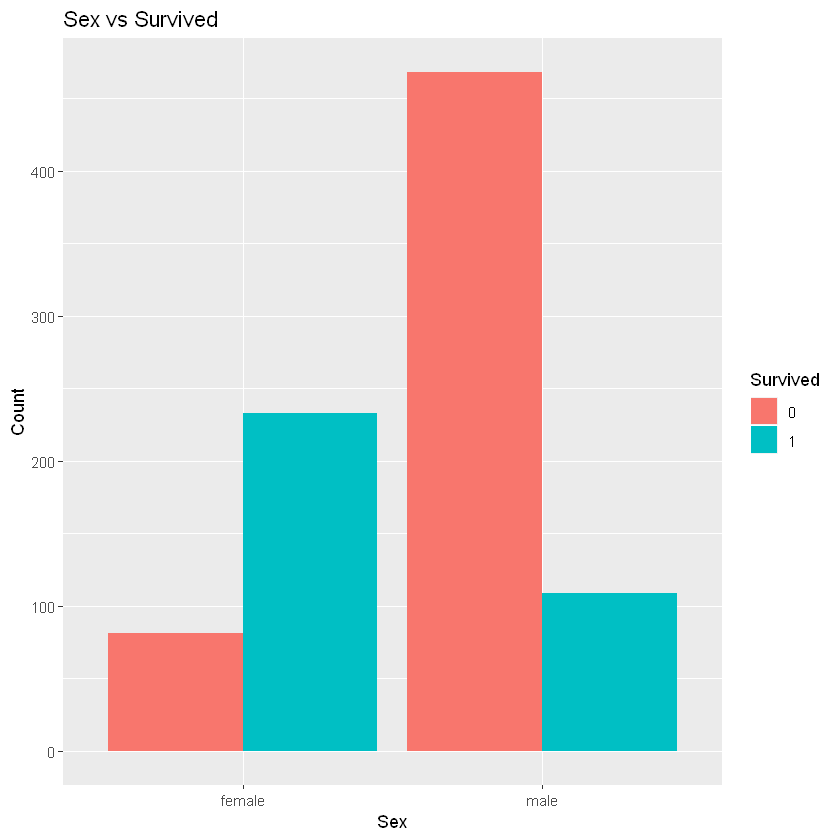

In [79]:
#second attribute we are considering is sex for inferences

ggplot(titanic[1:891,], aes(Sex, fill = factor(Survived))) + 
  geom_bar(stat = "count", position = 'dodge')+
  xlab("Sex") +
  ylab("Count") +
  scale_fill_discrete(name = "Survived") + 
  ggtitle("Sex vs Survived")

In [80]:
t=table(titanic[1:LT,]$Sex,titanic[1:LT,]$Survived)
for(i in 1:dim(t)[1]){
    t[i,]=t[i,]/sum(t[i,])*100
}
t

        
                0        1
  female 25.79618 74.20382
  male   81.10919 18.89081

In [81]:
#inference2: female has 74% chance of suvival in comparison with male 18%


In [82]:
str(titanic)

'data.frame':	1309 obs. of  14 variables:
 $ PassengerId: int  1 2 3 4 5 6 7 8 9 10 ...
 $ Survived   : Factor w/ 2 levels "0","1": 1 2 2 2 1 1 1 1 2 2 ...
 $ Pclass     : Factor w/ 3 levels "1","2","3": 3 1 3 1 3 3 1 3 3 2 ...
 $ Name       : chr  "Braund, Mr. Owen Harris" "Cumings, Mrs. John Bradley (Florence Briggs Thayer)" "Heikkinen, Miss. Laina" "Futrelle, Mrs. Jacques Heath (Lily May Peel)" ...
 $ Sex        : Factor w/ 2 levels "female","male": 2 1 1 1 2 2 2 2 1 1 ...
 $ Age        : num  22 38 26 35 35 25 54 2 27 14 ...
 $ SibSp      : int  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch      : int  0 0 0 0 0 0 0 1 2 0 ...
 $ Ticket     : chr  "A/5 21171" "PC 17599" "STON/O2. 3101282" "113803" ...
 $ Fare       : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Cabin      : chr  "" "C85" "" "C123" ...
 $ Embarked   : Factor w/ 3 levels "C","Q","S": 3 1 3 3 3 2 3 3 3 1 ...
 $ Title      : Factor w/ 5 levels "Master","Miss",..: 3 4 2 4 3 3 3 1 4 4 ...
 $ FamilySize : Factor w/ 3 levels "Single","Small",.

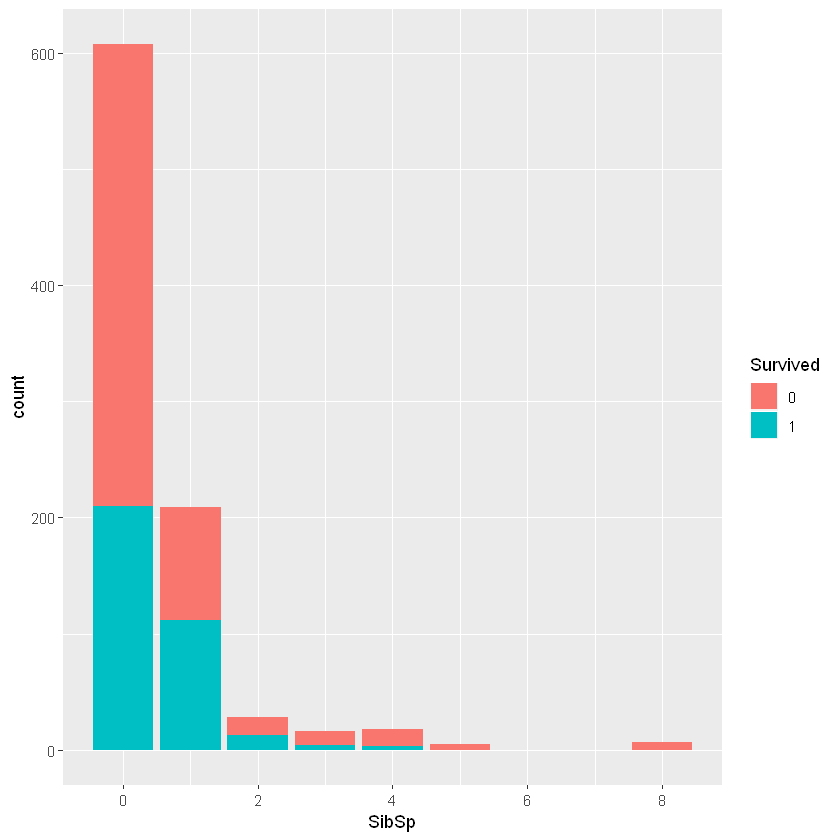

In [87]:
#attribute considered are sibsp and parch for next inference

ggplot(data = titanic[1:LT,],aes(x=SibSp,fill=Survived))+geom_bar()

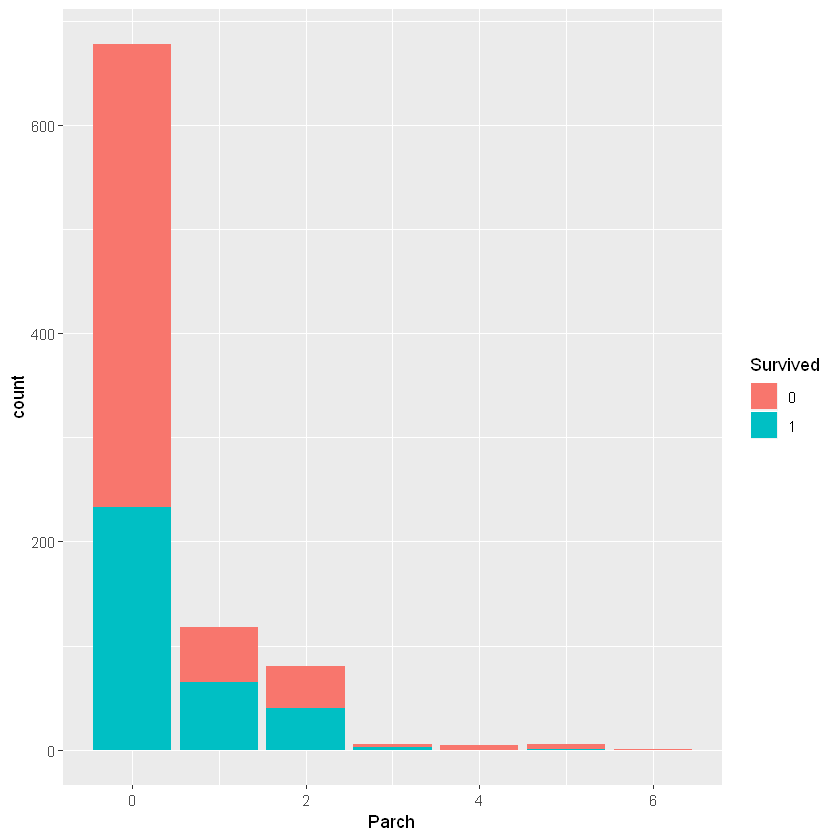

In [90]:
ggplot(data= titanic[1:LT,],aes(x=Parch,fill=Survived))+geom_bar()

Warning message:
"Removed 4 rows containing missing values (geom_bar)."

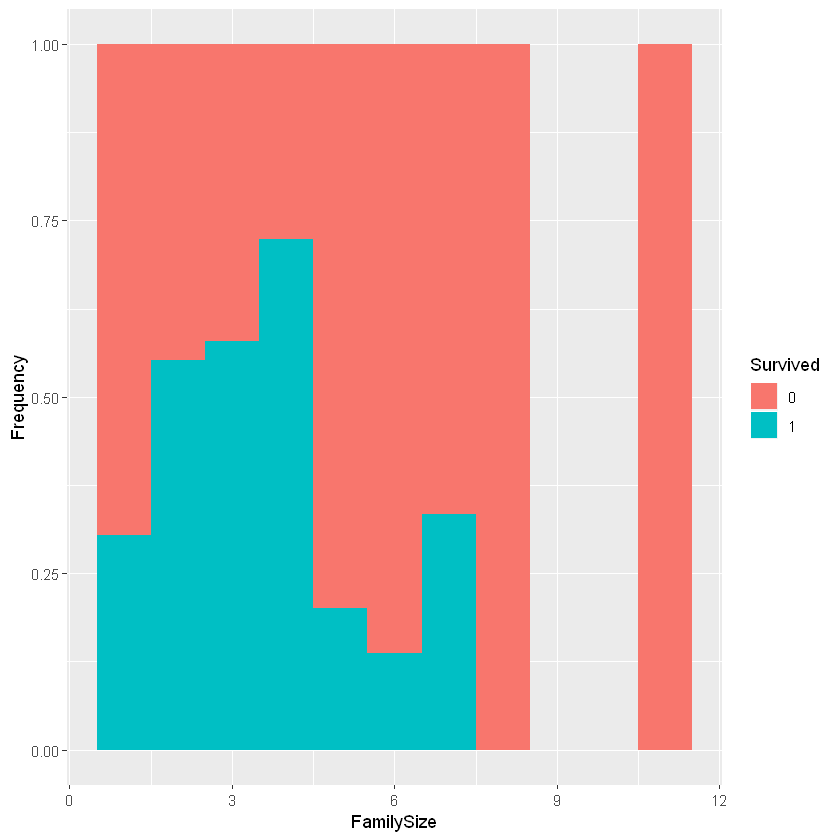

In [91]:
titanic$FamilySize <- titanic$SibSp + titanic$Parch +1;
titanic1<-titanic[1:LT,]
ggplot(data = titanic1[!is.na(titanic[1:LT,]$FamilySize),],aes(x=FamilySize,fill=Survived))+geom_histogram(binwidth =1,position="fill")+ylab("Frequency")

In [92]:
# inference 3 family with familysize between 2 to 4 has more than 50% chance of survival

In [93]:
str(titanic)

'data.frame':	1309 obs. of  14 variables:
 $ PassengerId: int  1 2 3 4 5 6 7 8 9 10 ...
 $ Survived   : Factor w/ 2 levels "0","1": 1 2 2 2 1 1 1 1 2 2 ...
 $ Pclass     : Factor w/ 3 levels "1","2","3": 3 1 3 1 3 3 1 3 3 2 ...
 $ Name       : chr  "Braund, Mr. Owen Harris" "Cumings, Mrs. John Bradley (Florence Briggs Thayer)" "Heikkinen, Miss. Laina" "Futrelle, Mrs. Jacques Heath (Lily May Peel)" ...
 $ Sex        : Factor w/ 2 levels "female","male": 2 1 1 1 2 2 2 2 1 1 ...
 $ Age        : num  22 38 26 35 35 25 54 2 27 14 ...
 $ SibSp      : int  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch      : int  0 0 0 0 0 0 0 1 2 0 ...
 $ Ticket     : chr  "A/5 21171" "PC 17599" "STON/O2. 3101282" "113803" ...
 $ Fare       : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Cabin      : chr  "" "C85" "" "C123" ...
 $ Embarked   : Factor w/ 3 levels "C","Q","S": 3 1 3 3 3 2 3 3 3 1 ...
 $ Title      : Factor w/ 5 levels "Master","Miss",..: 3 4 2 4 3 3 3 1 4 4 ...
 $ FamilySize : num  2 2 1 2 1 1 1 5 3 2 ...


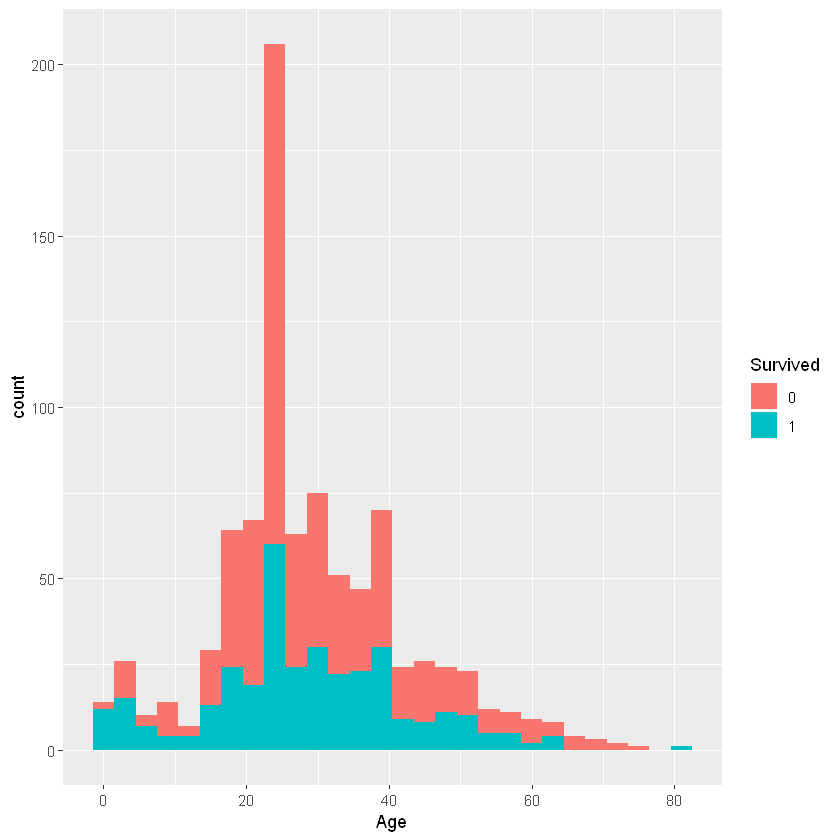

In [94]:
#age next attribute considered
ggplot(data = titanic1[!(is.na(titanic[1:LT,]$Age)),],aes(x=Age,fill=Survived))+geom_histogram(binwidth =3)

Warning message:
"Removed 2 rows containing missing values (geom_bar)."

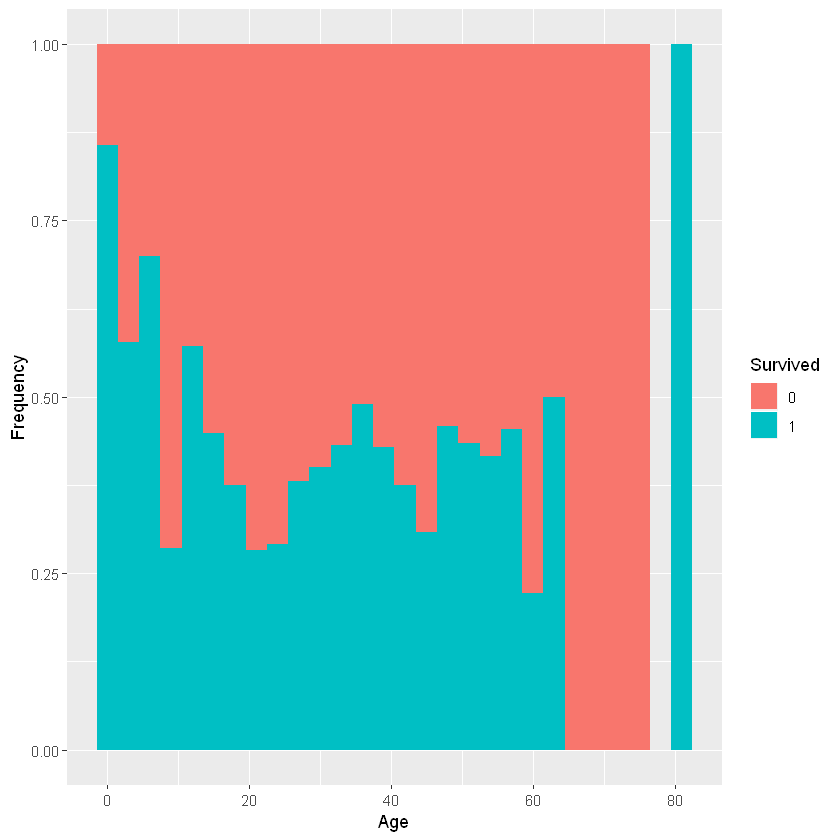

In [96]:
ggplot(data = titanic1[!is.na(titanic[1:LT,]$Age),],aes(x=Age,fill=Survived))+geom_histogram(binwidth = 3,position="fill")+ylab("Frequency")

In [97]:
#inference4  children upto age 15 and old people above age 80 has better chance of survival

In [98]:
str(titanic)

'data.frame':	1309 obs. of  14 variables:
 $ PassengerId: int  1 2 3 4 5 6 7 8 9 10 ...
 $ Survived   : Factor w/ 2 levels "0","1": 1 2 2 2 1 1 1 1 2 2 ...
 $ Pclass     : Factor w/ 3 levels "1","2","3": 3 1 3 1 3 3 1 3 3 2 ...
 $ Name       : chr  "Braund, Mr. Owen Harris" "Cumings, Mrs. John Bradley (Florence Briggs Thayer)" "Heikkinen, Miss. Laina" "Futrelle, Mrs. Jacques Heath (Lily May Peel)" ...
 $ Sex        : Factor w/ 2 levels "female","male": 2 1 1 1 2 2 2 2 1 1 ...
 $ Age        : num  22 38 26 35 35 25 54 2 27 14 ...
 $ SibSp      : int  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch      : int  0 0 0 0 0 0 0 1 2 0 ...
 $ Ticket     : chr  "A/5 21171" "PC 17599" "STON/O2. 3101282" "113803" ...
 $ Fare       : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Cabin      : chr  "" "C85" "" "C123" ...
 $ Embarked   : Factor w/ 3 levels "C","Q","S": 3 1 3 3 3 2 3 3 3 1 ...
 $ Title      : Factor w/ 5 levels "Master","Miss",..: 3 4 2 4 3 3 3 1 4 4 ...
 $ FamilySize : num  2 2 1 2 1 1 1 5 3 2 ...


Warning message:
"Removed 28 rows containing missing values (geom_bar)."

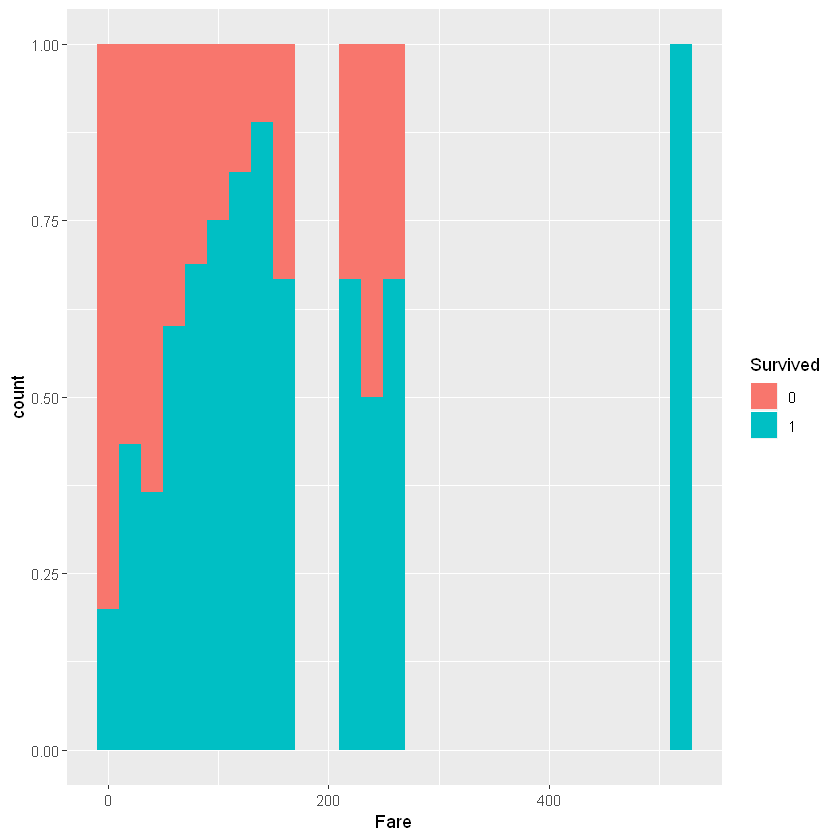

In [100]:
#next attribute considered is fare
ggplot(data = titanic[1:LT,],aes(x=Fare,fill=Survived))+geom_histogram(binwidth =20, position="fill")

In [101]:
#inference5 if fare is bigger,you have a better chance of survival

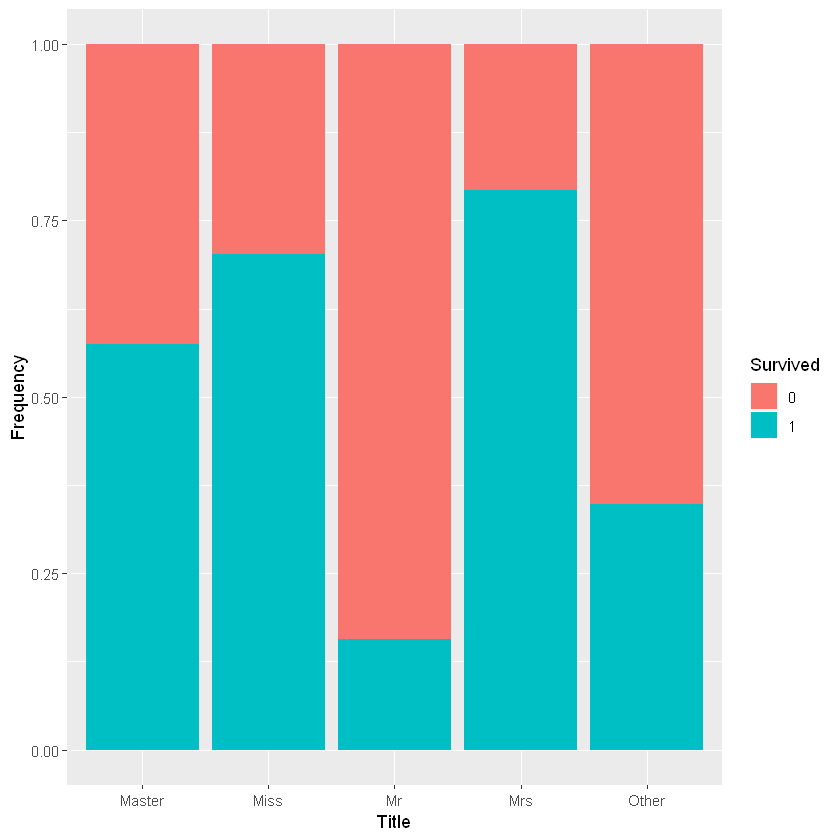

In [108]:
#attribute considered is title
ggplot(data = titanic[1:LT,],aes(x=Title,fill=Survived))+geom_bar(position="fill")+ylab("Frequency")

In [103]:
#inference6 if You are child(male,female) or you are lady u have much better chance of survival